# ASQUIRE DATA LOADING

In [40]:
from matplotlib import pyplot as plt
import praat_formants_python as pfp
from parselmouth.praat import call
import IPython.display as ipd
from scipy import signal
import soundfile as sf
from tqdm import tqdm
import pandas as pd
import parselmouth
import numpy as np
import subprocess
import functools
import librosa
import shutil
import glob
import json
import os

from lib.asqlib import *

## DATA PATHS

In [41]:
EXP_VER = "v12"
REPORT_FOLDER = f"report_{EXP_VER}"

ASQ_MUSTER_CSV = f"{REPORT_FOLDER}/asquire_corpus_muster.csv"
ASQ_LABELS_CSV = f"{REPORT_FOLDER}/all_asq_aud_anotes.csv"

In [42]:
pd.read_csv(ASQ_MUSTER_CSV)

,index,sub_id,age,gender,height,weight,meta-data--file_path,anot--meta-data--file_path,breath--file_path,anot--breath--file_path,...,uu--file_path,anot--uu--file_path,yee--file_path,anot--yee--file_path,zz--file_path,anot--zz--file_path,sent--file_path,anot--sent--file_path,~noise~--file_path,anot--~noise~--file_path
0,0,qwer-0177a438,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,1,bugsbunny-13f848d8,-,-,-,-,-,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,...,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-
2,2,doll-808ed97a,-,-,-,-,-,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,...,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-
3,3,varun-8f78ac35,-,-,-,-,-,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,...,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-
4,4,murugeswari-d700dff3,-,-,-,-,-,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,...,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,227,harisk-6f82d610,58,m,175,88,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,-,-,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,-,-,-,-
228,228,arhaam-350fc3e6,6,m,114,30,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,-,-,-,-,-,-,-,-
229,229,ravisk-cd186836,60,m,177,83,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,-,-,-,-
230,230,srinivas-b89febe6,60,m,172,85,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,-,-,-,-


#### ALL LABELS

In [43]:
pd.read_csv(ASQ_LABELS_CSV)["label"].unique()

array(['oo', 'yy', 'cc', 'ss', 'aa', 'uu', 'ii', 'xx', 'ee', 'zz', 'ii-n'],
      dtype=object)

#### ALL COLUMNS

In [44]:
pd.read_csv(ASQ_LABELS_CSV).columns

Index(['app_code', 'sub_id', 'file_class', 'file_xindex', 'score',
       'file_format', 'file_name', 'file_path', 'file_match',
       'anot--file_format', 'anot--file_name', 'anot--file_path', 'age',
       'gender', 'height', 'weight', 'start', 'end', 'label', 'line_number',
       'dur'],
      dtype='object')

### CLASS: MAKE DATA FOLDS -> ASQ_SUB_LABEL_STAT_DF

In [63]:
class StimStats(DataStaticInfo):

    LABELS = ['aa', 'ee', 'uu', 'oo', 'ii', 'xx', 'cc', 'yy', 'ss',  'zz', 'ii-n']

    PAD = 0.0
    WIN_DUR = 0.52
    AUTOCORR_K = 32
    LPC_K = 16

    FOLD_k = "fold"
    TOTAL_k = "total"

    ASQ_SUBJECT_LABEL_STAT_FNAME = "asq_subject_label_stats"

    ASQ_ANNOTATION_DF: pd.DataFrame
    ASQ_SUB_LABEL_STAT_DF: pd.DataFrame

    def __init__(self, annotation_csv: str) -> None:

        self.ASQ_ANNOTATION_DF = pd.read_csv(annotation_csv)
        self.ASQ_SUB_LABEL_STAT_DF = self.sub_label_stat()
    
    def sub_label_stat(self, label_df: pd.DataFrame|bool=False) -> pd.DataFrame:

        if not type(label_df) == pd.DataFrame:
            label_df = self.ASQ_ANNOTATION_DF

        label_df = label_df.copy()

        sub_dicts = []
        for sid in self.get_subjects():

            
            filt = label_df[self.fkeys['SID']] == sid
            sub_df: pd.DataFrame = label_df[filt]
            
            sub_dict = {
                f"{self.fkeys['SID']}": sid,
            } | sub_df.iloc[0][[self.GENDER_k, self.AGE_k]].to_dict()

            sub_dict[self.TOTAL_k] = sub_df[self.DUR_k].sum()

            for label in self.LABELS:
                filt = sub_df[self.LABEL_k] == label
                sub_label_stats_df = sub_df[filt]

                # count = sub_label_df.shape[0]
                total_dur = np.round(sub_label_stats_df[self.DUR_k].sum(), 2)
                mean_dur = np.round(sub_label_stats_df[self.DUR_k].mean(), 2)
                std_dur = np.round(sub_label_stats_df[self.DUR_k].std(), 2)
                cov = np.round(std_dur/mean_dur, 2)
                
                sub_dict[f"{label}_count"] = sub_label_stats_df.shape[0]
                sub_dict[f"{label}_{self.DUR_k}"] = total_dur
                sub_dict[f"{label}_mean"] = mean_dur
                sub_dict[f"{label}_std"] = std_dur
                sub_dict[f"{label}_cov"] = cov

            sub_dicts.append(sub_dict)

        sub_label_stats_df =  pd.DataFrame(sub_dicts)
        sub_label_stats_df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)


        export_path = os.path.join(REPORT_FOLDER, 
                                   f"{self.ASQ_SUBJECT_LABEL_STAT_FNAME}.csv")
        
        sub_label_stats_df.to_csv(export_path, index=False)
        
        return sub_label_stats_df


    def make_folds(self, df: pd.DataFrame, n) -> pd.DataFrame:
        df = df.copy()

        df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)

        groups = []
        group_sums = np.zeros(n)

        for _, rv in df.iterrows():
            # Find the group with the smallest sum and assign the current row to it
            min_sum_index = np.argmin(group_sums)
            groups.append((rv[self.fkeys['SID']], min_sum_index))
            group_sums[min_sum_index] += rv[self.TOTAL_k]

        # Create a new DataFrame with the group assignments
        grouped_data = pd.DataFrame(groups, columns=[self.fkeys['SID'], self.FOLD_k])

        # Merge the original DataFrame with the grouped data
        result_df = df.merge(grouped_data, on=[self.fkeys['SID']])

        return result_df

    def get_fold_stats(self, df: pd.DataFrame|bool=False) -> pd.DataFrame:
        assert type(df) == pd.DataFrame, "df must be a pandas DataFrame"

        fold_info_dicts = []
        
        for f in sorted(df[self.FOLD_k].unique()):
            filt = df[self.FOLD_k] == f
            fold_df: pd.DataFrame = df[filt]

            fold_dict = {
                self.FOLD_k: f,
                self.TOTAL_k: fold_df.shape[0],
            } 
            fold_dict |= fold_df[self.GENDER_k].value_counts().to_dict()
            fold_dict |={f"{k}%": np.round(v * 100, 1) for k, v in fold_df[self.GENDER_k].value_counts(normalize=True).to_dict().items()}

            fold_dict |= fold_df[self.LABEL_k].value_counts().to_dict()
            fold_dict |= {f"{k}%": np.round(v * 100, 1) for k, v in fold_df[self.LABEL_k].value_counts(normalize=True).to_dict().items()}

            fold_info_dicts.append(fold_dict)

        fold_stat_df = pd.DataFrame(fold_info_dicts)

        return fold_stat_df

    def get_subjects(self, df: pd.DataFrame=False) -> list:
        if not type(df) == pd.DataFrame:
            df = self.ASQ_ANNOTATION_DF
        return df[self.fkeys['SID']].unique()
    
    def gender_filter(self, df, gender: str):
        filt = df[self.GENDER_k] == gender
        return df[filt]
    
    def make_frames(self, sig, frame_size, hop_size):
        N = len(sig)
        sig_chunks = np.array([sig[i:i + frame_size] for i in range(0, N - frame_size + 1, hop_size)])
        return sig_chunks

    def viz_random_chunk(self, df: pd.DataFrame, cmap='inferno') -> ipd.Audio:
        label_df = df

        i = np.random.randint(0, label_df.shape[0])

        rv = label_df.iloc[i]

        sid = rv[self.fkeys['SID']]
        audio_path = rv[self.fkeys['FPATH']]
        begin = rv[self.BEGIN_k]
        end = rv[self.END_k]
        label = rv[self.LABEL_k]

        sig, fs = librosa.load(audio_path, sr=16000, offset=begin-self.PAD, duration=(end - begin + 2*self.PAD))

        sig = np.hanning(len(sig)) * sig

        # info
        print(f"fs: {fs}")
        print(f"sig.shape: {sig.shape}")

        self.plot_spectrogram(sig, fs, f"{label}, {sid}", cmap=cmap)
        # self.plot_sig(sig, fs, label)
        self.plot_autocorrelation(sig)
        
        return ipd.Audio(sig, rate=fs)

    def plot_spectrogram(self, sig, fs, label, cmap='inferno'):
        f, t, Sxx = signal.spectrogram(sig, fs)

        plt.figure(figsize=(16, 6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap=cmap)  # Convert to dB scale
        plt.ylabel('Frequency [Hz]'); plt.xlabel('Time [sec]')
        plt.title(f"{label}")
        plt.colorbar(label='Intensity [dB]')
        plt.ylim(0, fs / 2)  # Limit the y-axis to the positive frequency range
        plt.tight_layout()

        plt.show()

    def plot_autocorrelation(self, sig):
        N = len(sig)
        frame_size = N // (64 * 2)
        hop_size = frame_size // 2

        sig_chunks = self.make_frames(sig, frame_size, hop_size)

        res = librosa.autocorrelate(sig_chunks, max_size=self.AUTOCORR_K, axis=0)
        print(f"sig_chunks.shape: {res.shape}")

        plt.imshow(np.flip(res), cmap='inferno')
        
        plt.show()
    
        res2 = librosa.lpc(sig_chunks, order=self.LPC_K, axis=0)
        plt.imshow(np.flip(res2), cmap='inferno')
        
        plt.show()

    def plot_sig(self, aud, fs, label, scale=1.0, c='blue'):
        plt.title(f"{label}", fontsize=12)
        t = np.linspace(0, len(aud)/fs, len(aud))
        plt.plot(t, aud*scale, color=c)
        
        plt.show()

asq_datafolds = StimStats(annotation_csv=ASQ_LABELS_CSV)
label_stat_df = asq_datafolds.ASQ_SUB_LABEL_STAT_DF; label_stat_df

,sub_id,gender,age,total,aa_count,aa_dur,aa_mean,aa_std,aa_cov,ee_count,...,zz_count,zz_dur,zz_mean,zz_std,zz_cov,ii-n_count,ii-n_dur,ii-n_mean,ii-n_std,ii-n_cov
62,prarthana-39ab5a79,f,20,610.565051,9,89.84,9.98,8.45,0.85,9,...,0,0.00,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN
1,adarsh-d13557e5,m,18,566.227994,13,161.11,12.39,2.22,0.18,6,...,0,0.00,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN
48,selenator-2f05f52b,f,20,510.292020,3,66.91,22.30,3.29,0.15,3,...,3,80.15,26.72,1.83,0.07,0,0.0,NaN,NaN,NaN
149,sumit-19f76935,m,23,507.722595,6,121.22,20.20,4.14,0.20,3,...,3,46.72,15.57,3.27,0.21,0,0.0,NaN,NaN,NaN
5,priyanshu-aa13e502,m,20,477.564539,9,69.35,7.71,1.31,0.17,6,...,6,75.78,12.63,1.14,0.09,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,pragnaniranjan-8fa5dd73,f,20,3.355849,0,0.00,NaN,NaN,NaN,0,...,0,0.00,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN
36,bani-0395d07a,f,20,2.995102,0,0.00,NaN,NaN,NaN,0,...,0,0.00,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN
10,uyiut-c544cde3,f,6,1.433579,0,0.00,NaN,NaN,NaN,0,...,0,0.00,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN
170,ananyach-9a6a2c78,f,20,1.348735,0,0.00,NaN,NaN,NaN,0,...,0,0.00,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN


In [46]:
label_stat_df.describe()

,age,total,aa_count,aa_dur,aa_mean,aa_std,aa_cov,ee_count,ee_dur,ee_mean,...,zz_count,zz_dur,zz_mean,zz_std,zz_cov,ii-n_count,ii-n_dur,ii-n_mean,ii-n_std,ii-n_cov
count,203.000000,203.000000,203.000000,203.000000,166.000000,135.000000,135.000000,203.000000,203.000000,165.000000,...,203.000000,203.000000,140.000000,115.000000,115.000000,203.000000,203.000000,18.000000,15.000000,15.000000
mean,23.906404,170.865296,2.645320,25.854680,10.201265,1.861259,0.200222,2.748768,27.558621,10.951939,...,2.113300,18.397340,9.388357,1.474522,0.170087,0.315271,0.693202,2.106111,0.322000,0.139333
std,10.484128,126.362790,2.090127,24.698611,5.547923,1.603138,0.146407,2.085057,22.516718,6.240850,...,1.942737,18.410735,5.333498,1.269233,0.122263,1.197817,2.781931,0.635658,0.237793,0.097282
min,6.000000,0.787329,0.000000,0.000000,1.070000,0.060000,0.030000,0.000000,0.000000,1.500000,...,0.000000,0.000000,0.900000,0.020000,0.000000,0.000000,0.000000,1.100000,0.030000,0.010000
25%,19.000000,72.024680,1.000000,8.275000,6.585000,0.865000,0.105000,1.000000,9.350000,6.800000,...,0.000000,0.000000,5.797500,0.615000,0.090000,0.000000,0.000000,1.560000,0.135000,0.095000
50%,21.000000,143.684627,3.000000,22.450000,9.105000,1.460000,0.160000,3.000000,26.360000,9.840000,...,3.000000,16.740000,8.785000,1.080000,0.140000,0.000000,0.000000,2.125000,0.300000,0.140000
75%,23.000000,248.406337,3.000000,36.730000,12.600000,2.255000,0.250000,3.000000,43.280000,13.970000,...,3.000000,30.410000,12.125000,1.920000,0.230000,0.000000,0.000000,2.420000,0.480000,0.165000
max,60.000000,610.565051,13.000000,161.110000,33.000000,9.620000,0.850000,10.000000,100.930000,33.610000,...,11.000000,81.680000,33.780000,8.370000,0.720000,9.000000,22.180000,3.170000,0.910000,0.430000


In [47]:
class StimFolds(StimStats):

    FOLD_LABELS: list

    PAD = 0.0
    WIN_DUR = 0.52
    MIN_LABEL_DUR = 16.0

    FOLD_k = "fold"
    TOTAL_k = "total"

    ASQ_SUBJECT_LABEL_FOLDS_FNAME = f"asq_subject_label_folds"

    N_FOLDS: int

    ASQ_LABEL_FOLD_DF: pd.DataFrame
    ASQ_LABEL_SPLIT_DF: pd.DataFrame

    def __init__(self, annotation_csv: str, n_folds: int, labels: list) -> None:
        super().__init__(annotation_csv)

        self.N_FOLDS = n_folds
        self.FOLD_LABELS = labels

        self.ASQ_LABEL_FOLD_DF = self.sub_label_filt(self.ASQ_SUB_LABEL_STAT_DF)
        self.ASQ_LABEL_SPLIT_DF = self.split_chunks(self.ASQ_LABEL_FOLD_DF)


    def sub_label_filt(self, label_stat_df: pd.DataFrame|bool=False) -> pd.DataFrame:

        if not type(label_stat_df) == pd.DataFrame:
            label_stat_df = self.ASQ_SUB_LABEL_STAT_DF

        fold_labels = self.FOLD_LABELS

        label_stat_df = label_stat_df.copy()

        # duration filter
        filts = [label_stat_df[f"{l}_dur"] > self.MIN_LABEL_DUR for l in fold_labels]
        filt = functools.reduce(lambda p, c: p & c, filts)

        label_filt_stat_df = label_stat_df[filt]

        cols = [self.fkeys['SID'], self.AGE_k, self.GENDER_k]
        cols += label_filt_stat_df.columns[label_filt_stat_df.columns.str.contains('|'.join(fold_labels))].tolist()
        label_filt_stat_df = label_filt_stat_df[cols]

        dur_cols = label_filt_stat_df.columns[label_filt_stat_df.columns.str.contains(self.DUR_k)].tolist()
        label_filt_stat_df[self.TOTAL_k] = label_filt_stat_df[dur_cols].sum(axis=1)
        label_filt_stat_df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)

        genders = ['f', 'm']

        label_folds_dfs = [self.make_folds(self.gender_filter(label_filt_stat_df, g), self.N_FOLDS) for g in genders]

        label_folds_df =  pd.concat(label_folds_dfs)

        filt_subjects = self.get_subjects(label_folds_df)

        filt = self.ASQ_ANNOTATION_DF[self.fkeys['SID']].isin(filt_subjects)
        filt &= self.ASQ_ANNOTATION_DF[self.LABEL_k].isin(fold_labels)


        label_filt_df = self.ASQ_ANNOTATION_DF[filt]

        label_filt_df = label_filt_df.merge(label_folds_df[[self.fkeys['SID'], self.FOLD_k]], on=[self.fkeys['SID']])

        export_path = os.path.join(REPORT_FOLDER, 
                                   f"{self.ASQ_SUBJECT_LABEL_FOLDS_FNAME}_{'-'.join(fold_labels)}_{self.N_FOLDS}.csv")

        label_filt_df.to_csv(export_path, index=False)

        return label_filt_df


    def split_chunks(self, df: pd.DataFrame, win_dur: float|bool=False) -> pd.DataFrame:
        
        if type(win_dur) == bool:
            win_dur = self.WIN_DUR

        df = df.copy()

        new_rows = []
        for i, row in df.iterrows():
            start = row[self.BEGIN_k]
            dur = row[self.DUR_k]

            segments = np.floor(dur / win_dur)

            for i in range(int(segments)):
                new_start = start + i * win_dur
                new_end = new_start + win_dur

                new_row = row.copy()
                new_row[self.BEGIN_k] = new_start
                new_row[self.END_k] = new_end
                new_row[self.DUR_k] = win_dur

                new_rows.append(new_row)

        new_df = pd.DataFrame(new_rows)    

        return new_df

    

asq_labelfolds = StimFolds(ASQ_LABELS_CSV, n_folds=5, labels=['ii', 'xx'])
label_split_df = asq_labelfolds.ASQ_LABEL_SPLIT_DF; label_split_df 

,app_code,sub_id,file_class,file_xindex,score,file_format,file_name,file_path,file_match,anot--file_format,...,age,gender,height,weight,start,end,label,line_number,dur,fold
0,webapp-asquire-mox,navneeth-498e541d,breath,9,NaN,wav,webapp-asquire-mox_navneeth-498e541d_breath_9_...,report_v12/asquire_data/navneeth-498e541d/weba...,webapp-asquire-mox_navneeth-498e541d_breath_9_NA,txt,...,28,m,180,80,1.313968,1.833968,ii,1,0.52,3
0,webapp-asquire-mox,navneeth-498e541d,breath,9,NaN,wav,webapp-asquire-mox_navneeth-498e541d_breath_9_...,report_v12/asquire_data/navneeth-498e541d/weba...,webapp-asquire-mox_navneeth-498e541d_breath_9_NA,txt,...,28,m,180,80,1.833968,2.353968,ii,1,0.52,3
0,webapp-asquire-mox,navneeth-498e541d,breath,9,NaN,wav,webapp-asquire-mox_navneeth-498e541d_breath_9_...,report_v12/asquire_data/navneeth-498e541d/weba...,webapp-asquire-mox_navneeth-498e541d_breath_9_NA,txt,...,28,m,180,80,2.353968,2.873968,ii,1,0.52,3
0,webapp-asquire-mox,navneeth-498e541d,breath,9,NaN,wav,webapp-asquire-mox_navneeth-498e541d_breath_9_...,report_v12/asquire_data/navneeth-498e541d/weba...,webapp-asquire-mox_navneeth-498e541d_breath_9_NA,txt,...,28,m,180,80,2.873968,3.393968,ii,1,0.52,3
1,webapp-asquire-mox,navneeth-498e541d,breath,9,NaN,wav,webapp-asquire-mox_navneeth-498e541d_breath_9_...,report_v12/asquire_data/navneeth-498e541d/weba...,webapp-asquire-mox_navneeth-498e541d_breath_9_NA,txt,...,28,m,180,80,3.746205,4.266205,xx,2,0.52,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,webapp-asquire-mox,ravisk-cd186836,breath,6,NaN,wav,webapp-asquire-mox_ravisk-cd186836_breath_6_NA...,report_v12/asquire_data/ravisk-cd186836/webapp...,webapp-asquire-mox_ravisk-cd186836_breath_6_NA,txt,...,60,m,177,83,44.763741,45.283741,ii,19,0.52,4
210,webapp-asquire-mox,ravisk-cd186836,breath,6,NaN,wav,webapp-asquire-mox_ravisk-cd186836_breath_6_NA...,report_v12/asquire_data/ravisk-cd186836/webapp...,webapp-asquire-mox_ravisk-cd186836_breath_6_NA,txt,...,60,m,177,83,45.349038,45.869038,xx,20,0.52,4
210,webapp-asquire-mox,ravisk-cd186836,breath,6,NaN,wav,webapp-asquire-mox_ravisk-cd186836_breath_6_NA...,report_v12/asquire_data/ravisk-cd186836/webapp...,webapp-asquire-mox_ravisk-cd186836_breath_6_NA,txt,...,60,m,177,83,45.869038,46.389038,xx,20,0.52,4
210,webapp-asquire-mox,ravisk-cd186836,breath,6,NaN,wav,webapp-asquire-mox_ravisk-cd186836_breath_6_NA...,report_v12/asquire_data/ravisk-cd186836/webapp...,webapp-asquire-mox_ravisk-cd186836_breath_6_NA,txt,...,60,m,177,83,46.389038,46.909038,xx,20,0.52,4


In [54]:
asq_labelfolds.get_fold_stats(label_split_df)

,fold,total,f,m,f%,m%,xx,ii,xx%,ii%
0,0,216,110.0,106,50.9,49.1,119,97,55.1,44.9
1,1,186,92.0,94,49.5,50.5,104,82,55.9,44.1
2,2,243,84.0,159,34.6,65.4,147,96,60.5,39.5
3,3,224,64.0,160,28.6,71.4,114,110,50.9,49.1
4,4,166,NaN,166,NaN,100.0,93,73,56.0,44.0


fs: 16000
sig.shape: (8320,)


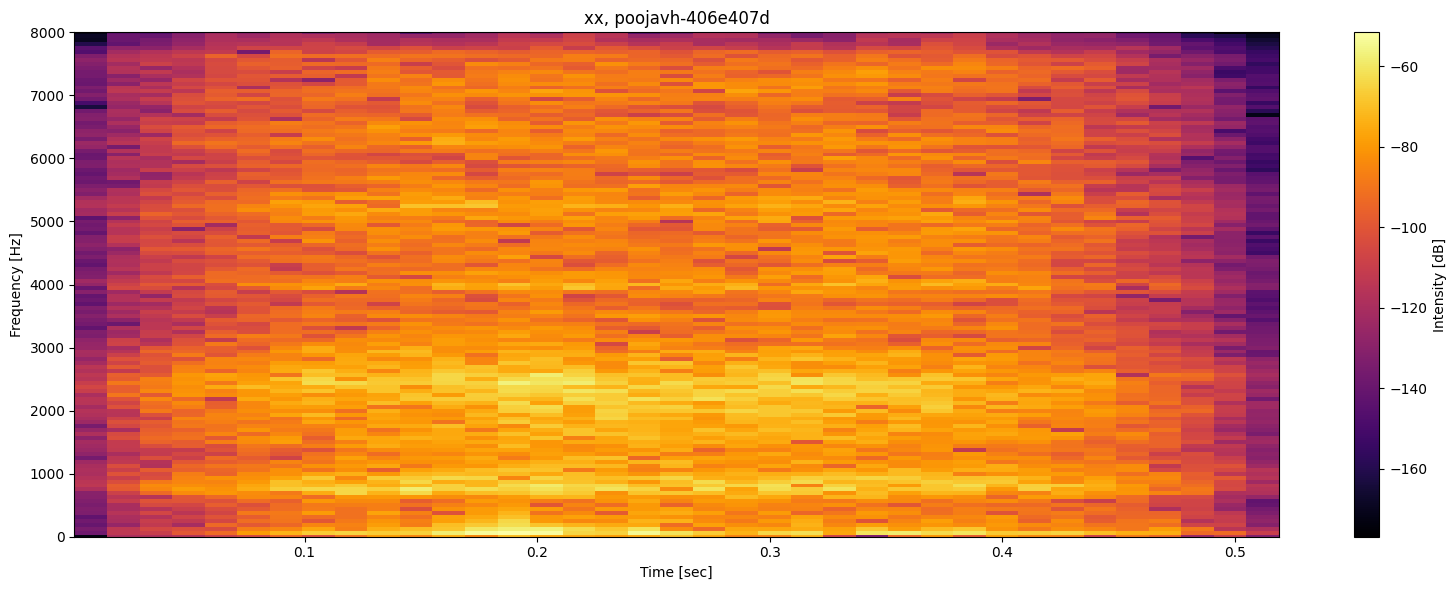

sig_chunks.shape: (32, 65)


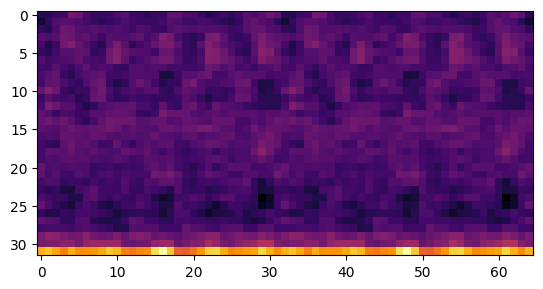

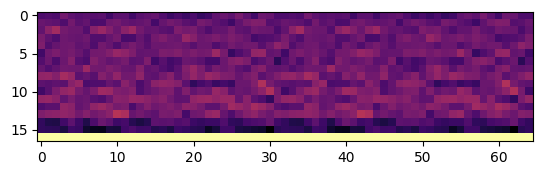

In [62]:
asq_labelfolds.viz_random_chunk(asq_labelfolds.ASQ_LABEL_SPLIT_DF)

### CLASS: MAKE VOWEL FOLDS -> ASQ_SUBJECT_VOWEL_FOLDS_FNAME

In [ ]:
class VowelFolds(StimFolds):

    FOLD_LABELS: ['aa', 'ee', 'uu']


    ASQ_SUBJECT_VOWEL_FOLDS_FNAME = f"asq_subject_vowel_folds"

    N_FOLDS: int

    ASQ_LABEL_FOLD_DF: pd.DataFrame
    ASQ_LABEL_SPLIT_DF: pd.DataFrame

    def __init__(self, annotation_csv: str, n_folds: int) -> None:
        super().__init__(annotation_csv, )

        self.N_FOLDS = n_folds

        self.ASQ_LABEL_FOLD_DF = self.sub_label_filt(self.ASQ_SUB_LABEL_STAT_DF)
        self.ASQ_LABEL_SPLIT_DF = self.split_chunks(self.ASQ_LABEL_FOLD_DF)


asq_labelfolds = StimFolds(ASQ_LABELS_CSV, n_folds=5, labels=['ii', 'xx'])
label_split_df = asq_labelfolds.ASQ_LABEL_SPLIT_DF; label_split_df 

In [9]:
class VowelFolds(StimStats):

    VOW_LABELS = ['aa'] #, 'ee', 'uu', 'ss', 'zz']

    PAD = 0.0
    WIN_DUR = 0.52
    MIN_VOWEL_DUR = 16.0

    FOLD_k = "fold"
    TOTAL_k = "total"

    ASQ_SUBJECT_VOWEL_FOLDS_FNAME = "asq_subject_vowel_folds_f"

    N_FOLDS: int

    ASQ_VOWEL_FOLD_DF: pd.DataFrame
    ASQ_VOWEL_SPLIT_DF: pd.DataFrame

    def __init__(self, annotation_csv: str, folds: int) -> None:
        super().__init__(annotation_csv)

        self.N_FOLDS = folds

        self.ASQ_VOWEL_FOLD_DF = self.sub_vowel_filt(self.ASQ_SUB_LABEL_STAT_DF)
        self.ASQ_VOWEL_SPLIT_DF = self.split_chunks(self.ASQ_VOWEL_FOLD_DF)


    def sub_vowel_filt(self, label_stat_df: pd.DataFrame|bool=False) -> pd.DataFrame:

        if not type(label_stat_df) == pd.DataFrame:
            label_stat_df = self.ASQ_SUB_LABEL_STAT_DF

        label_stat_df = label_stat_df.copy()

        # duration filter
        filts = [label_stat_df[f"{l}_dur"] > self.MIN_VOWEL_DUR for l in self.VOW_LABELS]
        filt = functools.reduce(lambda p, c: p & c, filts)

        vowel_stat_df = label_stat_df[filt]

        cols = ['sub_id', self.AGE_k, self.GENDER_k]
        cols += vowel_stat_df.columns[vowel_stat_df.columns.str.contains('|'.join(self.VOW_LABELS))].tolist()
        vowel_stat_df = vowel_stat_df[cols]

        dur_cols = vowel_stat_df.columns[vowel_stat_df.columns.str.contains(self.DUR_k)].tolist()
        vowel_stat_df[self.TOTAL_k] = vowel_stat_df[dur_cols].sum(axis=1)
        vowel_stat_df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)

        genders = ['f', 'm']

        vowel_folds_dfs = [self.make_folds(self.gender_filter(vowel_stat_df, g), self.N_FOLDS) for g in genders]

        vowel_folds_df =  pd.concat(vowel_folds_dfs)

        filt_subjects = self.get_subjects(vowel_folds_df)

        filt = self.ASQ_ANNOTATION_DF[self.fkeys['SID']].isin(filt_subjects)
        filt &= self.ASQ_ANNOTATION_DF[self.LABEL_k].isin(self.VOW_LABELS)


        vowel_filt_df = self.ASQ_ANNOTATION_DF[filt]

        vowel_filt_df = vowel_filt_df.merge(vowel_folds_df[[self.fkeys['SID'], self.FOLD_k]], on=[self.fkeys['SID']])

        export_path = os.path.join(REPORT_FOLDER, 
                                   f"{self.ASQ_SUBJECT_VOWEL_FOLDS_FNAME}_{self.N_FOLDS}.csv")

        vowel_filt_df.to_csv(export_path, index=False)

        return vowel_filt_df

    def estimate_vowel_formants(self, vowel_info: pd.Series) -> dict:
        audio_file = vowel_info["audio_filepath"]
        start_sec = vowel_info["start_second"]
        end_sec = vowel_info["end_second"]
        vowel_name = vowel_info["vowel_name"]

        formant_estimates = self.measure_formants_pfp(audio_file, start_sec, end_sec)
        # formant_estimates = measure_formants_psm(audio_file, vowel_name, start_sec, end_sec)

        new_vowel_info = dict(vowel_info) | formant_estimates

        return new_vowel_info

    pfp.clear_formant_cache()

    def measure_formants_pfp(self, audio_path, start_sec, end_sec):
        formants = pfp.formants_at_interval(
            audio_path, start_sec, end_sec, maxformant=5500, winlen=0.5, preemph=50
        )

        pitch_mean = self.measure_pitch(audio_path)
        pitch_mean = np.round(pitch_mean, 2)
        
        formants_mean = formants.mean(axis=0)
        formants_mean = list(formants_mean)[1:]  # skip time
        formants_mean = np.round(formants_mean, 2)  # round

        formants_median = np.median(formants, axis=0)
        formants_median = list(formants_median)[1:]  # skip time
        formants_median = np.round(formants_median, 2) # round


        return {
            "pitch_mean_praat_base": pitch_mean,

            "F1_mean_praat_base": formants_mean[0],
            "F2_mean_praat_base": formants_mean[1],
            "F3_mean_praat_base": formants_mean[2],

            "F1_median_praat_base": formants_median[0],
            "F2_median_praat_base": formants_median[1],
            "F3_median_praat_base": formants_median[2],
        }
    
    def measure_pitch(self, audio_path: str) -> float:
        f0min, f0max = [75, 600]
        
        sound = parselmouth.Sound(audio_path) # read the sound
        pitch = call(sound, "To Pitch", 0, f0min, f0max) #create a praat pitch object
        mean_pitch = call(pitch, "Get mean", 0, 0, "Hertz") # get mean pitch
        return mean_pitch



    

asq_vowelfolds = VowelFolds(ASQ_LABELS_CSV, folds=5)
label_split_df = asq_vowelfolds.ASQ_VOWEL_SPLIT_DF; label_split_df 

,app_code,sub_id,file_class,file_xindex,score,file_format,file_name,file_path,file_match,anot--file_format,...,age,gender,height,weight,start,end,label,line_number,dur,fold
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,2.649042,3.169042,aa,1,0.52,0
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,3.169042,3.689042,aa,1,0.52,0
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,3.689042,4.209042,aa,1,0.52,0
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,4.209042,4.729042,aa,1,0.52,0
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,4.729042,5.249042,aa,1,0.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,29.351568,29.871568,aa,3,0.52,1
450,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,29.871568,30.391568,aa,3,0.52,1
450,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,30.391568,30.911568,aa,3,0.52,1
450,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,30.911568,31.431568,aa,3,0.52,1


In [10]:
asq_vowelfolds.get_fold_stats(label_split_df)

,fold,total,m,f,m%,f%,aa,aa%
0,0,1773,1223,550,69.0,31.0,1773,100.0
1,1,1792,1252,540,69.9,30.1,1792,100.0
2,2,1822,1252,570,68.7,31.3,1822,100.0
3,3,1816,1245,571,68.6,31.4,1816,100.0
4,4,1803,1264,539,70.1,29.9,1803,100.0


In [11]:
asq_vowelfolds.get_subjects(label_split_df).__len__()

120

fs: 16000
sig.shape: (8320,)


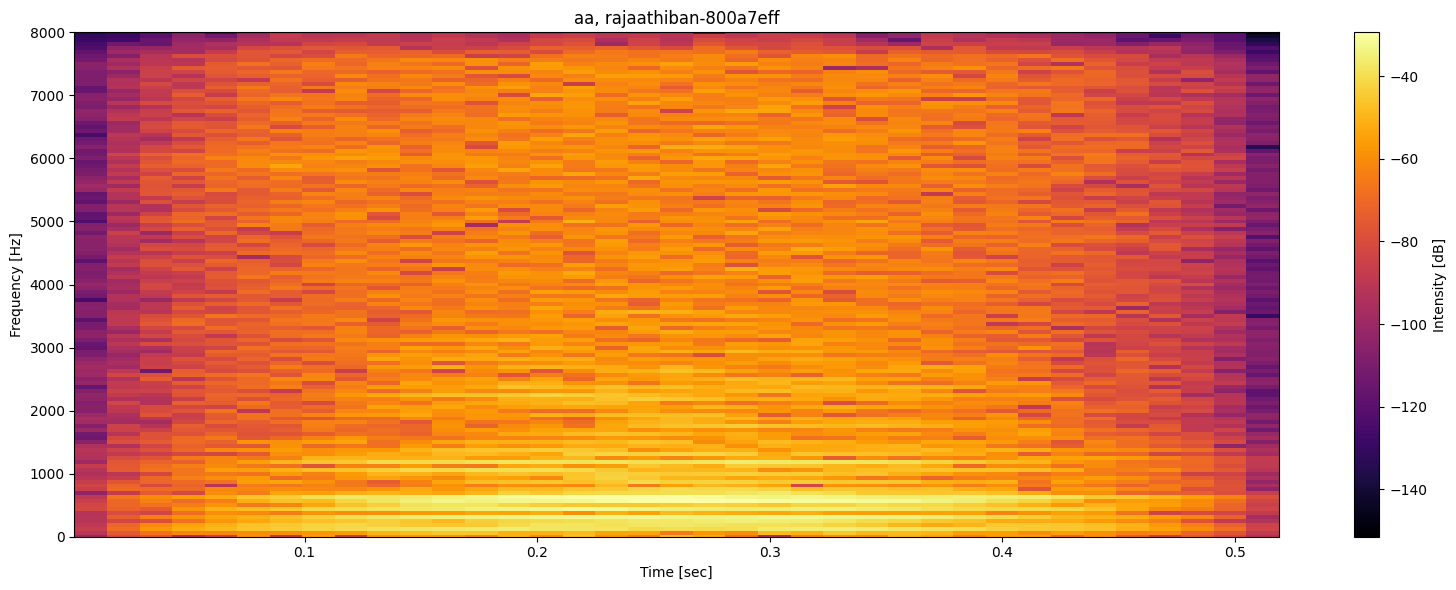

sig_chunks.shape: (64, 65)


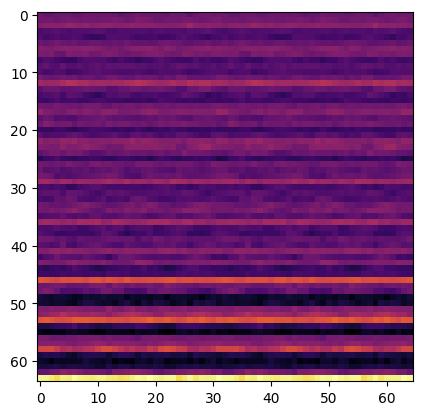

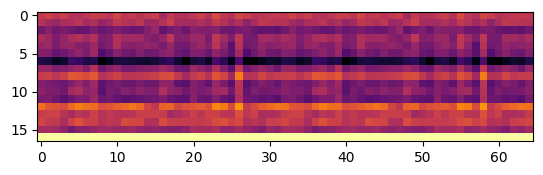

In [12]:
asq_vowelfolds.viz_random_chunk(label_split_df)

#### TESTS

In [13]:
# good ones
# autumn
# spring
# winter **
# magma **
# inferno **
# plasma
# viridis